# Multivariate to each input/output Time Series

In [54]:
import numpy as np
import time
import math
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error

import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters

import joblib
# https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/
# https://www.gritfeat.com/explainable-aixai-from-correlation-to-causation-shap-for-lstm-time-series-model/
#http://localhost:8888/lab/tree/MyQuantFinProject/TimeSeriesML-FinMarket/Nachiketa-Hebbar-LSTM/RNN_Youtube.ipynb

In [35]:
# ab_path = "../data/SET50-Daily-Y09-Now.csv"
# stockname='SET50'

ab_path = "../data/SPY-Daily-Y09-Now.csv"
stockname='SP500-SPY'

start_date='2012-01-01'
end_date='2022-12-31'

# EMA2 and Signal

my_features=['Price', 'EMA1','EMA2','EMA3','MACD', 'SIGNAL', 'RSI','RSI-MA']
#my_features=['Price', 'EMA1','EMA2','MACD', 'SIGNAL', 'RSI','RSI-MA']
# each feature predict itself

n_early=10

train_ratio=0.8


n_batch=32
n_epochs=100


main_obj_metric='mean_absolute_error'
main_loss='mean_absolute_error'


# 60 predict 1
n_input =60
# define generator

n_features = len(my_features)
print(f"input={n_input} and features={n_features}")

model_path='models'

tune_folder='oneInput_oneOut_SET50'


seed=7

# TUning Part

min_drop=0.0
max_drop=0.3
step_drop=0.1

ratio_traial_max=0.7  # 0.6/0.7
mx_step=3



input=60 and features=8


# Load Data

In [11]:
df=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
df.rename(columns={'Date/Time':'Date'},inplace=True)
allCols=list(df.columns)
print(allCols)

df['Date']=df['Date'].apply( lambda  dx :  datetime(dx.year,dx.month,dx.day ))
df.set_index('Date',inplace=True)
df=df.loc[start_date:end_date][my_features]
print(df.info())
print(df.tail(3))



['Ticker', 'Date', 'Price', 'EMA1', 'EMA2', 'EMA3', 'MACD', 'SIGNAL', 'RSI', 'RSI-MA']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2768 entries, 2012-01-03 to 2022-12-30
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2768 non-null   float64
 1   EMA1    2768 non-null   float64
 2   EMA2    2768 non-null   float64
 3   EMA3    2768 non-null   float64
 4   MACD    2768 non-null   float64
 5   SIGNAL  2768 non-null   float64
 6   RSI     2768 non-null   float64
 7   RSI-MA  2768 non-null   float64
dtypes: float64(8)
memory usage: 194.6 KB
None
             Price    EMA1    EMA2    EMA3  MACD  SIGNAL    RSI  RSI-MA
Date                                                                   
2022-12-28  376.66  384.11  387.86  387.86 -3.75   -0.88  39.42   42.69
2022-12-29  383.44  383.99  387.44  387.44 -3.45   -1.20  45.85   42.73
2022-12-30  382.43  383.70  386.97  386.97 -3.26   -1.46  45.09   43.38


# Tranform Data

In [12]:
print("Tranform Data")
dfValues=df.values
print(dfValues.shape)
train_data_len = math.ceil(len(dfValues) * train_ratio)
print(f"{train_ratio} of {len(dfValues)} = The number of train data is {train_data_len}")
train_values = dfValues[0:train_data_len]
test_values = dfValues[train_data_len:]
print(train_values.shape,test_values.shape)
    
from sklearn.preprocessing import MinMaxScaler,PowerTransformer
scaler = MinMaxScaler()
#scaler= PowerTransformer()
scaler.fit(train_values)
train = scaler.transform(train_values)
test = scaler.transform(test_values)

print(train.shape,test.shape)
print(type(train),type(test))
print(train[-2:])
print(test[-2:])

Tranform Data
(2768, 8)
0.8 of 2768 = The number of train data is 2215
(2215, 8) (553, 8)
(2215, 8) (553, 8)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[[0.93184188 0.9834336  0.99568906 0.99568906 0.82348754 0.7984306
  0.49481979 0.54239055]
 [0.93779322 0.98253569 0.99637698 0.99637698 0.81103203 0.80333497
  0.51481103 0.5147672 ]]
[[1.11181581 1.16090509 1.20527402 1.20527402 0.60391459 0.66208926
  0.40639136 0.28353023]
 [1.10742832 1.15960312 1.20311855 1.20311855 0.61067616 0.64933791
  0.39530133 0.29482279]]


# Generate Timeseries For LSTM

In [13]:
# each feature predict itself
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)
n_output=len(my_features)

# each feature predict one output , 0=close is targer 
# generator = TimeseriesGenerator(train,train[:,0], length=n_input, batch_size=1)
# n_output=1

# number of samples
print(f'Samples: {len(generator)}')
# print each sample
for i in range(len(generator)):
 x, y = generator[i]
 if i<=1:
    # n_output=y.shape[1]
    # print("Output: ",n_output)
    print(x.shape,y.shape)  
    print(f'{x} => {y}')
    print("=========================")
    


Samples: 2155
(1, 60, 8) (1, 8)
[[[0.         0.         0.         0.         0.7544484  0.73908779
   0.59346272 0.51181376]
  [0.00086881 0.00188561 0.00132997 0.00132997 0.75871886 0.74252084
   0.59988326 0.51685198]
  [0.00234579 0.00368142 0.0027058  0.0027058  0.76263345 0.7459539
   0.6109733  0.54100069]
  [0.00091225 0.0048936  0.00380647 0.00380647 0.76370107 0.74938695
   0.59433825 0.55072967]
  [0.00225891 0.00610577 0.00490713 0.00490713 0.76476868 0.75232957
   0.60572012 0.56931897]
  [0.0070808  0.00803628 0.00642055 0.00642055 0.76868327 0.75576263
   0.64541077 0.58165393]
  [0.00738488 0.00969741 0.00779638 0.00779638 0.77081851 0.75870525
   0.64789143 0.59312022]
  [0.00873154 0.01126874 0.00917221 0.00917221 0.77259786 0.7621383
   0.65941923 0.60458652]
  [0.00582103 0.01203197 0.01013529 0.01013529 0.77081851 0.76459049
   0.61666423 0.6099722 ]
  [0.00799305 0.01301966 0.01123596 0.01123596 0.77046263 0.76655223
   0.63738509 0.61744267]
  [0.01420504 0.0150

# LSTM Train

In [14]:
#neuron_number=100

np.random.seed(7)



In [15]:
#1 feature  to predict  1 output

print("Get n_input to set step for neuron")
neuron_number=n_input
step_neuron=int(neuron_number/1)
max_neuron=step_neuron*3
print(f"{neuron_number}= {n_input} (univariate n_features=1) with step {step_neuron} until {max_neuron}")



neuron_list = [*range(neuron_number, max_neuron+step_neuron, step_neuron)]

drop_list=np.arange (min_drop, max_drop ,step_drop)
drop_list=np.append(drop_list,[max_drop])

allPosComb=len(neuron_list)*len(drop_list)
print(f"{neuron_list} and {drop_list}")
print(f"all combination : {len(neuron_list)} x {len(drop_list)} = {allPosComb}")

nMax_trials=int(allPosComb*ratio_traial_max)
nExecutions_per_trial=3

print(f"Max Run={nMax_trials} of {allPosComb} e and each will repeat for essembling model= {nExecutions_per_trial}")



Get n_input to set step for neuron
60= 60 (univariate n_features=1) with step 60 until 180
[60, 120, 180] and [0.  0.1 0.2 0.3]
all combination : 3 x 4 = 12
Max Run=8 of 12 e and each will repeat for essembling model= 3


In [16]:
# def my_model(neuron_number,dropout_rate,isTuning):   
def my_model(neuron_number,dropout_rate):  
 model = Sequential()

 model.add(LSTM(units=neuron_number, activation='relu',return_sequences=False, input_shape=(n_input, n_features))) 
 
# if (isTuning==True) or (isTuning==False and dropout_rate>0):
 #  model.add(Dropout(dropout_rate))  
 # else:
 #  print(f"Ignore drop rate {dropout_rate}")  
 model.add(Dropout(dropout_rate))    

 model.add(Dense(n_output))

#https://keras.io/api/metrics/
#https://keras.io/api/losses/
 # model.compile(loss=tf.keras.losses.mean_absolute_error,\
 #               optimizer='adam',metrics =[tf.keras.metrics.mean_absolute_error])
 model.compile(loss=main_loss,\
               optimizer='adam',metrics =[main_obj_metric])   

 return model


# Tunine Step

In [17]:
def build_hp_model(hp):
    x_neuron_number=hp.Int('input_unit',min_value=neuron_number ,max_value=max_neuron,step=step_neuron)
    x_dropout_rate=hp.Float('Dropout_rate',min_value=min_drop,max_value=max_drop,step=step_drop)
    
    # model=my_model( x_neuron_number, x_dropout_rate,True)
    model=my_model( x_neuron_number, x_dropout_rate)

    return model
# create emply HyperParameters data
build_hp_model(kt.HyperParameters())


In [18]:
t_Start=time.time()

print(f"Start tund at {datetime.now()}")

buildtime = datetime.now().strftime('%d%m%y_%H%M')
project_model=f"multi_inout_bayesian{buildtime}"
print(project_model)

Start tund at 2023-01-14 19:12:20.398160
multi_inout_bayesian140123_1912


In [19]:

tuner = kt.BayesianOptimization(
# tuner = kt.Hyperband(
# tuner= kt.RandomSearch(
        build_hp_model,
        max_trials=nMax_trials,
        objective=main_obj_metric,
        seed=seed,
        executions_per_trial=nExecutions_per_trial,
        directory=f"tuning/{tune_folder}/",
        project_name= project_model   
        )

if (n_early>0):
 early_stop = EarlyStopping(monitor='loss', patience=n_early, verbose=1)
 tuner.search(generator, batch_size=n_batch, epochs=n_epochs,
                        shuffle=False,verbose=1,callbacks=[early_stop])
else:
 tuner.search(generator, batch_size=n_batch, epochs=n_epochs,
                        shuffle=False,verbose=1)   


Trial 8 Complete [01h 10m 46s]
mean_absolute_error: 0.014718697095910708

Best mean_absolute_error So Far: 0.013888772577047348
Total elapsed time: 11h 14m 43s
INFO:tensorflow:Oracle triggered exit


In [20]:
print("Space to search")
tuner.search_space_summary()
print(f"Suumary of {nMax_trials}")
tuner.results_summary()

Space to search
Search space summary
Default search space size: 2
input_unit (Int)
{'default': None, 'conditions': [], 'min_value': 60, 'max_value': 180, 'step': 60, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
Suumary of 8
Results summary
Results in tuning/oneInput_oneOut_SET50/multi_inout_bayesian140123_1912
Showing 10 best trials
Trial summary
Hyperparameters:
input_unit: 60
Dropout_rate: 0.0
Score: 0.013888772577047348
Trial summary
Hyperparameters:
input_unit: 120
Dropout_rate: 0.0
Score: 0.014142305279771486
Trial summary
Hyperparameters:
input_unit: 60
Dropout_rate: 0.0
Score: 0.014419218835731348
Trial summary
Hyperparameters:
input_unit: 180
Dropout_rate: 0.0
Score: 0.014655473952492079
Trial summary
Hyperparameters:
input_unit: 60
Dropout_rate: 0.0
Score: 0.014718697095910708
Trial summary
Hyperparameters:
input_unit: 120
Dropout_rate: 0.1
Score: 0.023448993762334187
Trial summary


In [21]:
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execution : ',round(t_elapsed,2)) 
print(datetime.now())

Total execution :  11.25
2023-01-15 06:27:04.596013


In [36]:
print("Query the results")
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print("Show best hyperparamter values")
print(best_hps.values)
best_model=tuner.get_best_models(num_models=1)[0]
best_model.summary()


Query the results
Show best hyperparamter values
{'input_unit': 60, 'Dropout_rate': 0.0}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60)                16560     
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 8)                 488       
                                                                 
Total params: 17,048
Trainable params: 17,048
Non-trainable params: 0
_________________________________________________________________


# Build the model with the optimal hyperparameters and train it on the data for X epochs

In [37]:
print("# Build the model with the optimal hyperparameters and train it on the data for X epochs")
 # for retrain to get history and predict while develop 
# for save model as final output to train entire data
model = tuner.hypermodel.build(best_hps) 
model.summary()

# run muanyula
#model=my_model(neuron_number,0,False)

# Build the model with the optimal hyperparameters and train it on the data for X epochs
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 60)                16560     
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 488       
                                                                 
Total params: 17,048
Trainable params: 17,048
Non-trainable params: 0
_________________________________________________________________


In [38]:
print("Completed Tune")

Completed Tune


# Fit Model frpom best model

In [39]:
if (n_early>0):
 print("fit by early stop")   
 history=model.fit(generator,epochs=n_epochs,batch_size=n_batch,shuffle=False,callbacks=[early_stop],verbose=1)
else:
   history=model.fit(generator,epochs=n_epochs,batch_size=n_batch,shuffle=False,verbose=1)   

fit by early stop
Epoch 1/100
2155/2155 [==============================] - 29s 13ms/step - loss: 0.0491 - mean_absolute_error: 0.0491
Epoch 2/100
2155/2155 [==============================] - 27s 12ms/step - loss: 0.0449 - mean_absolute_error: 0.0449
Epoch 3/100
2155/2155 [==============================] - 27s 12ms/step - loss: 0.0364 - mean_absolute_error: 0.0364
Epoch 4/100
2155/2155 [==============================] - 27s 12ms/step - loss: 0.0298 - mean_absolute_error: 0.0298
Epoch 5/100
2155/2155 [==============================] - 27s 12ms/step - loss: 0.0239 - mean_absolute_error: 0.0239
Epoch 6/100
2155/2155 [==============================] - 27s 12ms/step - loss: 0.0237 - mean_absolute_error: 0.0237
Epoch 7/100
2155/2155 [==============================] - 27s 12ms/step - loss: 0.0222 - mean_absolute_error: 0.0222
Epoch 8/100
2155/2155 [==============================] - 27s 12ms/step - loss: 0.0213 - mean_absolute_error: 0.0213
Epoch 9/100
2155/2155 [==============================]

In [42]:
# for key,item in history.history.items():
#     print(key)
print(f"End TRaind tund at {datetime.now()}")
val_per_epoch = history.history[main_obj_metric]
#best_epoch = val_per_epoch.index(max(val_per_epoch)) + 1
best_epoch = len(val_per_epoch) + 1
print('Best epoch: %d' % (best_epoch,))

End TRaind tund at 2023-01-15 17:32:24.089988
Best epoch: 42


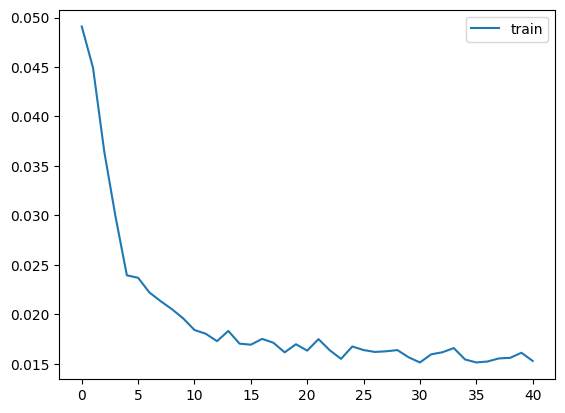

In [43]:
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

# Get Test Data(Unseen) by include {n_input_lookback} to predict

# Set Test data for prediction

In [44]:
# test_arr will get start with the last n look back to predict
idx_train_to_test=len(dfValues)-len(test_values)-n_input
print("The first train data to predict the frist test :",idx_train_to_test)



The first train data to predict the frist test : 2155


In [45]:
test_arr=dfValues[idx_train_to_test:]
print(f"Get Test Data {len(test_values)} + {n_input} to predict = {test_arr.shape}")
print(test_arr.shape)
test_scaled_arr=scaler.fit_transform(test_arr)
print(test_scaled_arr.shape)
print(test_scaled_arr[:2])


Get Test Data 553 + 60 to predict = (613, 8)
(613, 8)
(613, 8)
[[0.         0.         0.         0.         0.71167681 0.76657061
  0.54801444 0.63056439]
 [0.02523317 0.00413521 0.00388797 0.00388797 0.71333702 0.76512968
  0.61967509 0.61049285]]


In [46]:
#No.row = len(test_arr)-n_hop_lookback  , we will start triaing at the first rows since n_hop
X_test=[]
for i in range(n_input,test_scaled_arr.shape[0]):
   X_test.append(test_scaled_arr[i-n_input:i]) 
X_test=np.array(X_test)
print(X_test.shape)
print(X_test[:2])

(553, 60, 8)
[[[0.         0.         0.         0.         0.71167681 0.76657061
   0.54801444 0.63056439]
  [0.02523317 0.00413521 0.00388797 0.00388797 0.71333702 0.76512968
   0.61967509 0.61049285]
  [0.01782292 0.00617    0.00672158 0.00672158 0.70669618 0.7629683
   0.58971119 0.60651828]
  [0.03417657 0.01089596 0.01087315 0.01087315 0.71112341 0.76152738
   0.63574007 0.62380763]
  [0.04867765 0.0174598  0.01607908 0.01607908 0.72274488 0.76224784
   0.67454874 0.64030207]
  [0.0567906  0.02428618 0.0216145  0.0216145  0.73491976 0.76440922
   0.69584838 0.67289348]
  [0.06988629 0.0323597  0.02787479 0.02787479 0.75041505 0.76945245
   0.72960289 0.69693959]
  [0.08406797 0.0416147  0.03492586 0.03492586 0.76923077 0.77665706
   0.76462094 0.73549285]
  [0.08560112 0.0494913  0.04144975 0.04144975 0.78029884 0.78458213
   0.76841155 0.76470588]
  [0.09198927 0.05710535 0.04797364 0.04797364 0.7897067  0.79322767
   0.78465704 0.78895072]
  [0.07429411 0.06005907 0.0521911  0.

# Prediction

In [47]:
y_test_scaled_pred=model.predict(X_test)
print("Before Invert :",y_test_scaled_pred.shape)
y_test_scaled_pred[:3]

18/18 [==============================] - 1s 10ms/step
Before Invert : (553, 8)


array([[0.15923539, 0.18348068, 0.19256343, 0.18546116, 0.7315824 ,
        0.7788482 , 0.5559386 , 0.533698  ],
       [0.15975514, 0.18421508, 0.19360693, 0.18682754, 0.7292341 ,
        0.7805164 , 0.5468909 , 0.5165872 ],
       [0.16793197, 0.18967126, 0.199031  , 0.19247583, 0.730906  ,
        0.7804312 , 0.5664772 , 0.5177357 ]], dtype=float32)

In [48]:
y_test_pred=scaler.inverse_transform(y_test_scaled_pred)
print("After Invert :" ,y_test_pred.shape)
y_test_pred[:3]

After Invert : (553, 8)


array([[346.0967   , 349.5933   , 348.08148  , 347.00372  ,   3.149694 ,
          3.1604125,  56.599    ,  54.425682 ],
       [346.17807  , 349.70517  , 348.23984  , 347.21106  ,   3.10726  ,
          3.1835675,  56.09776  ,  53.564667 ],
       [347.45807  , 350.5364   , 349.06296  , 348.0682   ,   3.1374714,
          3.1823852,  57.182835 ,  53.622463 ]], dtype=float32)

# Create Predction DataFrame and Measure and Plot Chart

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Price        553 non-null    float64
 1   Price-Pred   553 non-null    float32
 2   EMA1         553 non-null    float64
 3   EMA1-Pred    553 non-null    float32
 4   EMA2         553 non-null    float64
 5   EMA2-Pred    553 non-null    float32
 6   EMA3         553 non-null    float64
 7   EMA3-Pred    553 non-null    float32
 8   MACD         553 non-null    float64
 9   MACD-Pred    553 non-null    float32
 10  SIGNAL       553 non-null    float64
 11  SIGNAL-Pred  553 non-null    float32
 12  RSI          553 non-null    float64
 13  RSI-Pred     553 non-null    float32
 14  RSI-MA       553 non-null    float64
 15  RSI-MA-Pred  553 non-null    float32
dtypes: float32(8), float64(8)
memory usage: 52.0 KB
None


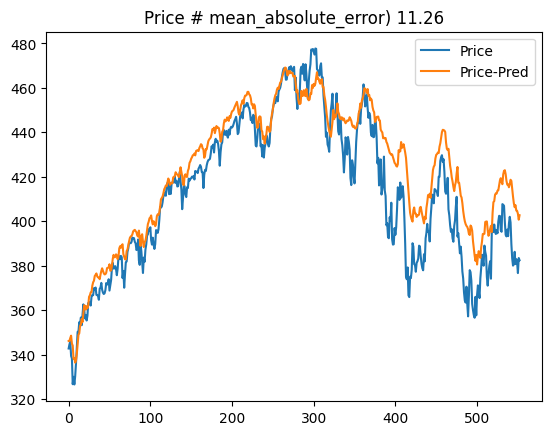

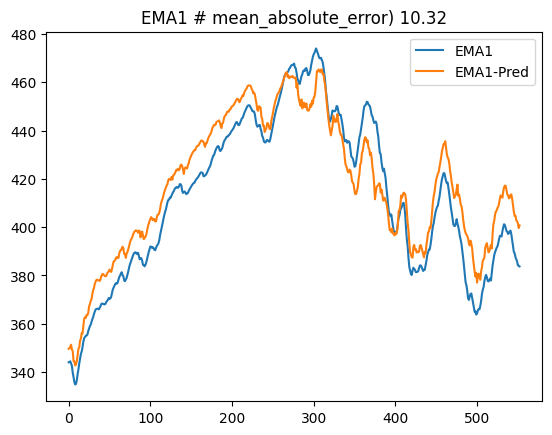

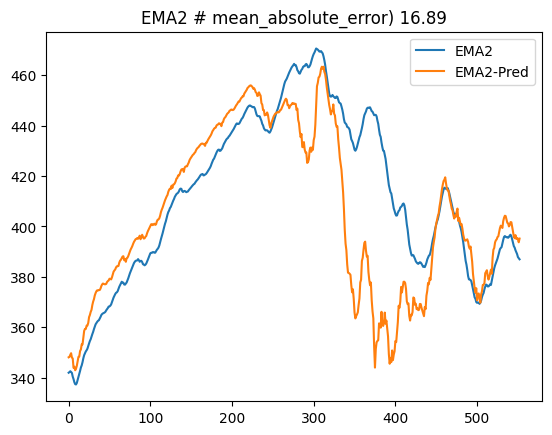

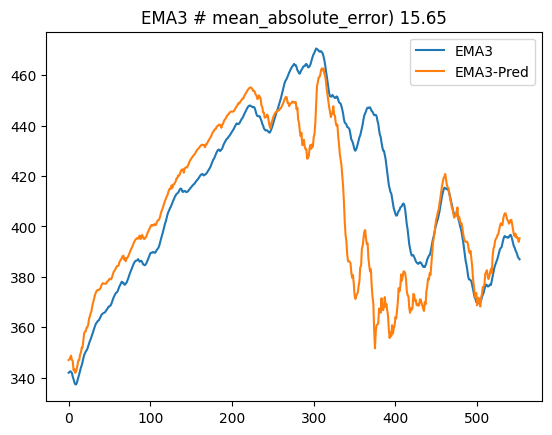

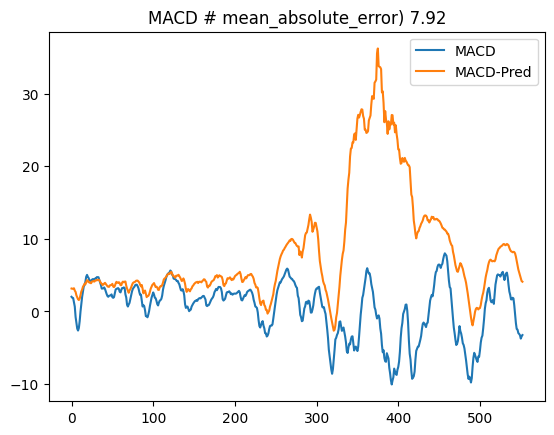

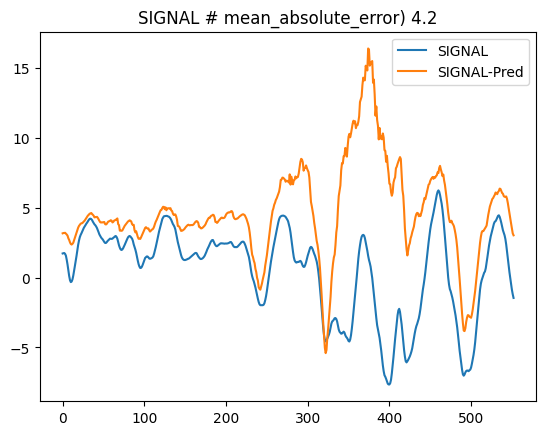

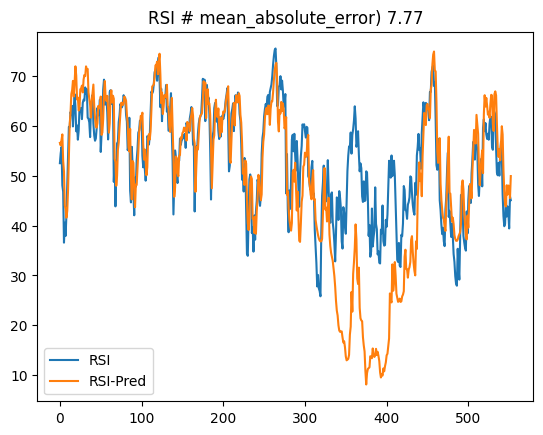

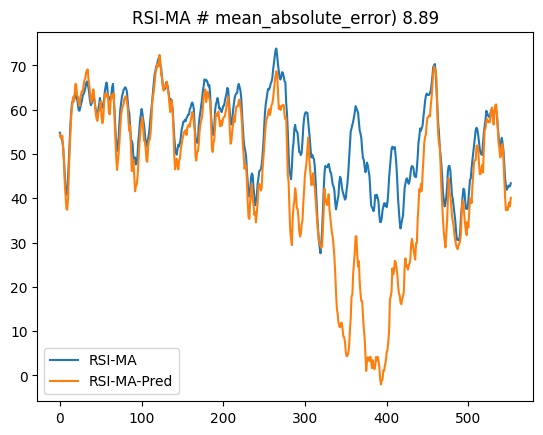

In [51]:
test_df=pd.DataFrame()
listColPair=[]
for i in range(0,len(my_features)): 
  dfActual=pd.DataFrame(data={my_features[i]:test_values[:,i]})  
  dfPred=pd.DataFrame(data={f'{my_features[i]}-Pred':y_test_pred[:,i]})
  listColPair.append([my_features[i],f'{my_features[i]}-Pred'])
  test_df=pd.concat([test_df,dfActual,dfPred],axis=1)
print(test_df.info())

#fig, axs = plt.subplots(nrows=len(listColPair), ncols=1, figsize=(14, 5*len(listColPair)))
for colPair in listColPair:
  # rmse = np.sqrt(mean_squared_error(test_df[colPair[0]], test_df[colPair[1]]))
  # title=f'{colPair[0]} # Root Mean Square Error(RMSE) {round(rmse,2)}'
  mae_x = mean_absolute_error(test_df[colPair[0]], test_df[colPair[1]])
  title=f'{colPair[0]} # {main_loss}) {round(mae_x,2)}'  
  test_df[colPair].plot(title=title)
  plt.legend()
  plt.show()

# Predict One Value

In [74]:
print(f"We will use the last {n_input} data to predict the new one")
last_train_batch=train[-n_input:]
print(last_train_batch.shape,last_train_batch)

print("We need reshape first")
last_train_batch =last_train_batch .reshape((1,n_input,n_features))
print(last_train_batch.shape,last_train_batch)

print("Predict")
last_predict=model.predict(last_train_batch)
print(last_predict)

last_predict = scaler.inverse_transform(last_predict)
print(last_predict.shape,last_predict)


We will use the last 60 data to predict the new one
(60, 8) [[0.39077227 0.37290137 0.38332009 0.38332009 0.73236426 0.76341324
  0.39903004 0.45659824]
 [0.37735634 0.36583795 0.37936811 0.37936811 0.71686618 0.75756279
  0.36710225 0.42463343]
 [0.37826847 0.36021298 0.37586718 0.37586718 0.70628474 0.75057078
  0.36993129 0.39398827]
 [0.39698617 0.35948302 0.37472884 0.37472884 0.70831552 0.74472032
  0.42758992 0.38651026]
 [0.38592657 0.35660612 0.37249511 0.37249511 0.70510902 0.73915525
  0.39795231 0.37082111]
 [0.40289602 0.35772253 0.37230181 0.37230181 0.7116289  0.73530251
  0.44914455 0.38181818]
 [0.39900046 0.35785135 0.3717219  0.3717219  0.71515605 0.73259132
  0.43782837 0.39721408]
 [0.42592733 0.36347632 0.37408449 0.37408449 0.73150919 0.73287671
  0.51488616 0.428739  ]
 [0.3979363  0.36233844 0.37320389 0.37320389 0.73011971 0.73287671
  0.43365216 0.43005865]
 [0.40025464 0.36188759 0.37266694 0.37266694 0.73054724 0.73301941
  0.44038798 0.43929619]
 [0.371370

In [57]:
print("Save model and scaler")
modelName=f'tuned_manyInOut-1To1_{n_input}_{stockname}'
#modelName='test2022-20for10'
file_model=f'{model_path}/{modelName}.h5'
file_scaler=f'{model_path}/scaler_{modelName}.gz'
file_scaler_pred=f'{model_path}/scaler_pred_{modelName}.gz'

model.save(file_model)
# joblib.dump(scaler_train,file_scaler)
# joblib.dump(file_scaler_pred,file_scaler_pred)

joblib.dump(scaler,file_scaler)


Save model and scaler


['models/scaler_tuned_manyInOut-1To1_60_SP500-SPY.gz']